![](https://storage.googleapis.com/kaggle-media/competitions/dsb-2018/dsb.jpg)

**The goal of this project is to train and build model that capable accurately identify
and semanticaly segment nuclei of cells on medical images.**

In [1]:
import os
import sys
import glob
import random
import datetime
import numpy as np
import pandas as pd
from tqdm import tqdm
import skimage.io                           #Used for imshow function
import skimage.transform                    #Used for resize function
from skimage.morphology import label        #Used for Run-Length-Encoding RLE to create final submission
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras.layers import Input, Conv2D, Lambda, MaxPooling2D, Conv2DTranspose, concatenate, Dropout, BatchNormalization
from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam, Adamax

print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Skimage      :', skimage.__version__)
print('Keras        :', keras.__version__)
print('Tensorflow   :', tf.__version__)

Python       : 3.6.6 |Anaconda, Inc.| (default, Oct  9 2018, 12:34:16) 
Numpy        : 1.18.1
Skimage      : 0.16.2
Keras        : 2.3.1
Tensorflow   : 2.1.0


Using TensorFlow backend.


In [2]:

!pip freeze > requirements.txt

In [3]:
# seed values
SEED = 42
random.seed = SEED
np.random.seed(seed=SEED)

# SETUP

In [4]:
# SETUP
TRAIN_PATH = 'train/'
TEST_PATH = 'test/'

IMG_WIDTH       = 320
IMG_HEIGHT      = 320
IMG_CHANNELS    = 3

BATCH_SIZE      = 32
NUM_EPOCHS      = 100

LR              = 0.001
validation_split= 0.15

# Load Data


In [5]:
# loading of data from zip files
import zipfile
for name_data in ['test', 'train']:
    tmp_zip = zipfile.ZipFile('../input/sf-dl-nucleus-detection/'+name_data+'.zip')
    tmp_zip.extractall(name_data)
    tmp_zip.close()

In [6]:
sample_submission = pd.read_csv('../input/sf-dl-nucleus-detection/sample_submission.csv')
sample_submission.sample(5)

,ImageId,EncodedPixels
53,d616d323a9eeb9da1b66f8d5df671d63c092c9919cb2c0...,1 1
60,eea70a7948d25a9a791dbcb39228af4ea4049fe5ebdee9...,1 1
0,0114f484a16c152baa2d82fdd43740880a762c93f436c8...,1 1
45,a4816cc1fb76cb3c5e481186833fc0ae9cf426a1406a26...,1 1
5,0f1f896d9ae5a04752d3239c690402c022db4d72c0d2c0...,1 1


In [7]:
train_labels = pd.read_csv('../input/sf-dl-nucleus-detection/train_labels.csv')
train_labels.sample(10)

,ImageId,EncodedPixels
16141,8b77284d6f37ab3fc826139ebadaec3b9d81c552fe525c...,55530 7 55784 12 56039 14 56294 16 56549 18 56...
27194,ea94ba4b01d1bd5f7768d10e0ac547743791033df545c7...,12295 8 12550 11 12805 14 13060 17 13316 18 13...
24216,cbca32daaae36a872a11da4eaff65d1068ff3f154eedc9...,37435 5 37690 7 37945 8 38201 8 38457 8 38713 ...
25304,da31f2aa8601afec5c45180a2c448cb9c4a8ec7b35e751...,18647 6 19166 8 19686 9 20206 9 20726 8 21247 ...
21273,b1f23c4d27afed8af7b6b64793a3760bfea31b65f582d4...,331026 5 331543 9 332062 12 332580 15 333099 1...
9796,538b7673d507014d83af238876e03617396b70fe27f525...,127462 4 128064 8 128666 12 129268 16 129870 2...
3410,1b44d22643830cd4f23c9deadb0bd499fb392fb2cd9526...,431986 4 433009 5 434033 5 435057 6 436081 6 4...
16126,8aa1a883f61f0bb5af3d3d60acaaf33af45ef4fbffaac1...,59092 3 59345 8 59600 11 59856 11 60112 11 603...
9577,4e23ecf65040f86420e0201134e538951acdeda84fbb27...,55041 2 55297 4 55553 5 55809 6 56065 6 56321 ...
27756,ee927e8255096971ddae1bd975cf80c4ad7c847c82d0b5...,23588 3 23843 5 24099 5 24355 5 24612 3


In [8]:
# I have around 29000 masks for 670 unique images.

len(train_labels) - train_labels.ImageId.duplicated().sum()

670

Сверяем по папкам

In [9]:
# More details about training data

# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))
test_ids = next(os.walk(TEST_PATH))

mask_count = 0
for train_id in train_ids[1]:
    masks = next(os.walk(TRAIN_PATH + train_id + '/masks/'))[2]
    mask_count += len(masks)

print('There are {} images.'.format(len(train_ids[1])))
print('There are {} masks.'.format(mask_count))
print('Approximately {} masks per image.'.format(mask_count // len(train_ids[1])))

There are 670 images.
There are 29461 masks.
Approximately 43 masks per image.


In [10]:
# The training data is 670 unique images. I have approximately 43 masks per image.
# The test data is 65 unique images.

In [11]:
#To convert images to arrays for training. I am using skimage library

def get_X_data(path, output_shape=(None, None)):
    '''
    Loads images from path/{id}/images/{id}.png into a numpy array
    '''
    img_paths = ['{0}/{1}/images/{1}.png'.format(path, id) for id in os.listdir(path)]
    X_data = np.array([skimage.transform.resize(skimage.io.imread(path)[:,:,:3], 
                                                output_shape=output_shape, 
                                                mode='constant', 
                                                preserve_range=True) for path in img_paths], dtype=np.uint8)  #take only 3 channels/bands
    
    return X_data

In [12]:
%%time
# Get training data
X_train = get_X_data(TRAIN_PATH, output_shape=(IMG_HEIGHT,IMG_WIDTH))
X_train.shape, X_train.dtype

CPU times: user 33.1 s, sys: 13.7 s, total: 46.9 s
Wall time: 25.6 s


((670, 320, 320, 3), dtype('uint8'))

In [13]:
# Masks Loading Function

def get_Y_data(path, output_shape=(None, None)):
    '''
    Loads and concatenates images from path/{id}/masks/{id}.png into a numpy array
    '''
    img_paths = [glob.glob('{0}/{1}/masks/*.png'.format(path, id)) for id in os.listdir(path)]
    
    Y_data = []
    for i, img_masks in enumerate(img_paths):  #loop through each individual nuclei for an image and combine them together
        masks = skimage.io.imread_collection(img_masks).concatenate()  #masks.shape = (num_masks, img_height, img_width)
        mask = np.max(masks, axis=0)                                   #mask.shape = (img_height, img_width)
        mask = skimage.transform.resize(mask, output_shape=output_shape+(1,), mode='constant', preserve_range=True)  #need to add an extra dimension so mask.shape = (img_height, img_width, 1)
        Y_data.append(mask)
    Y_data = np.array(Y_data, dtype=np.bool)
    
    return Y_data

In [14]:
%%time
# Get training data labels
Y_train = get_Y_data(TRAIN_PATH, output_shape=(IMG_HEIGHT,IMG_WIDTH))
print(Y_train.shape, Y_train.dtype)

(670, 320, 320, 1) bool
CPU times: user 1min 28s, sys: 31.7 s, total: 1min 59s
Wall time: 1min 15s


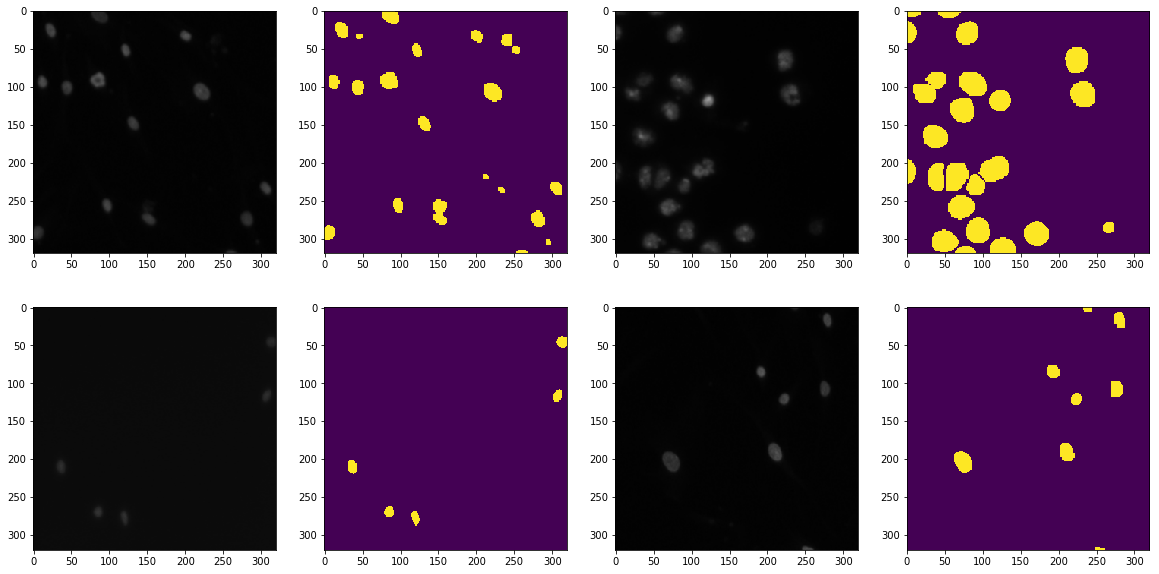

In [15]:
# Check training data
f, axarr = plt.subplots(2,4)
f.set_size_inches(20,10)
ix = random.randint(0, len(train_ids[1]))
axarr[0,0].imshow(X_train[ix])
axarr[0,1].imshow(np.squeeze(Y_train[ix]))

ix = random.randint(0, len(train_ids[1]))
axarr[0,2].imshow(X_train[ix])
axarr[0,3].imshow(np.squeeze(Y_train[ix]))

ix = random.randint(0, len(train_ids[1]))
axarr[1,0].imshow(X_train[ix])
axarr[1,1].imshow(np.squeeze(Y_train[ix]))

ix = random.randint(0, len(train_ids[1]))
axarr[1,2].imshow(X_train[ix])
axarr[1,3].imshow(np.squeeze(Y_train[ix]))

plt.show()

# 1.1 Augmentation

In [16]:
# I am going to use albumentation library for my Semantic Segmentation Models

In [17]:
!pip install -U albumentations==1.0.0

     |████████████████████████████████| 102kB 761kB/s 
  Found existing installation: albumentations 0.4.3
    Uninstalling albumentations-0.4.3:
      Successfully uninstalled albumentations-0.4.3


In [18]:
# import albumentations as A
# import cv2

# transform = A.Compose([
#     A.RandomCrop(width=IMG_WIDTH, height=IMG_HEIGHT),
#     A.RandomBrightnessContrast(p=1.0),
#     A.ShiftScaleRotate(always_apply=False, p=1.0, shift_limit=(-0.5, 0.5), scale_limit=(-0.2, 0.8), rotate_limit=(-180, 180), border_mode=4)
# #     A.Rotate(p=0.5),
# #     A.Rotate(p=1.0, always_apply=False, limit=(-0.5, -0.5), interpolation=0, border_mode=4, value=(0, 0, 0), mask_value=None)
# ])

In [19]:
import albumentations as A
import cv2

transform = A.Compose([
    A.HorizontalFlip(p=0.3),
    A.Rotate(limit=10, interpolation=1, border_mode=4, value=None, mask_value=None, always_apply=False, p=0.5),
    A.OneOf([
        A.CenterCrop(height=224, width=200),
        A.CenterCrop(height=200, width=224),
    ],p=0.4),
    A.OneOf([
        A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3),
        A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1)
    ],p=0.4),
    A.GaussianBlur(p=0.05),
    A.HueSaturationValue(p=0.35),
    A.RGBShift(p = 0.3),
    A.FancyPCA(alpha=0.1, always_apply=False, p=0.5),
    A.Resize(IMG_WIDTH, IMG_HEIGHT)
])

In [20]:
# To apply augmentation of images during the training, I am
# going to use ImageDataGenerator

datagen = ImageDataGenerator(
                                   transform,
                                   
                                   validation_split = validation_split,
                                   )

test_datagen = ImageDataGenerator(
    
                                 )




datagen.fit(X_train)

train_generator = datagen.flow(
    X_train, 
    Y_train, 
    batch_size=BATCH_SIZE / 2,
    subset='training')

test_generator = datagen.flow(
    X_train, 
    Y_train, 
    batch_size=8,
    subset='validation')

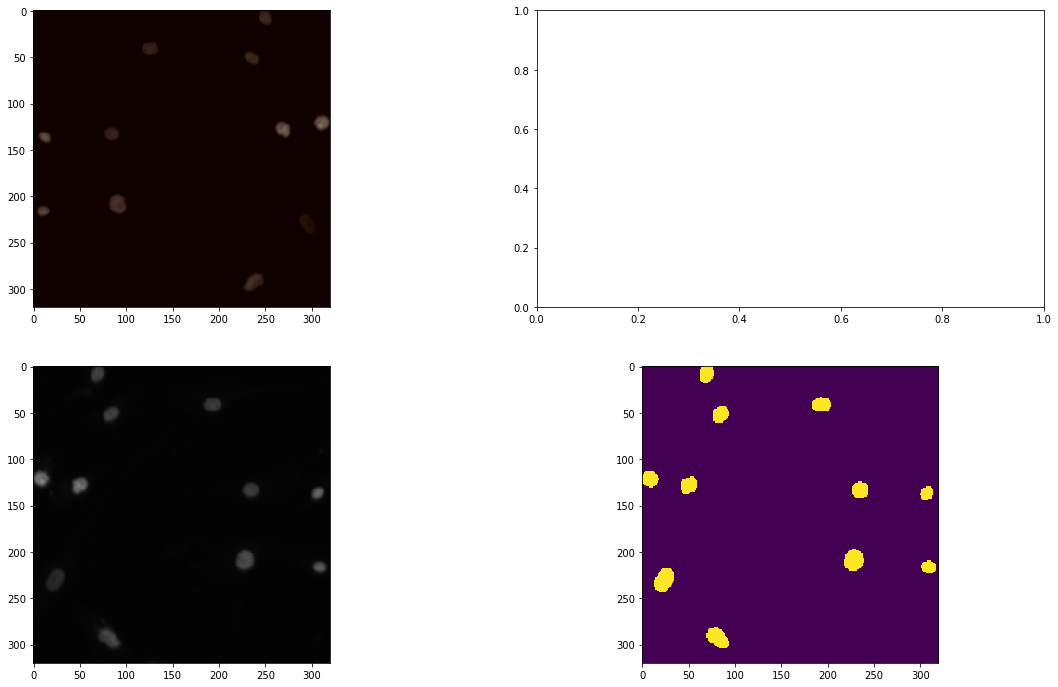

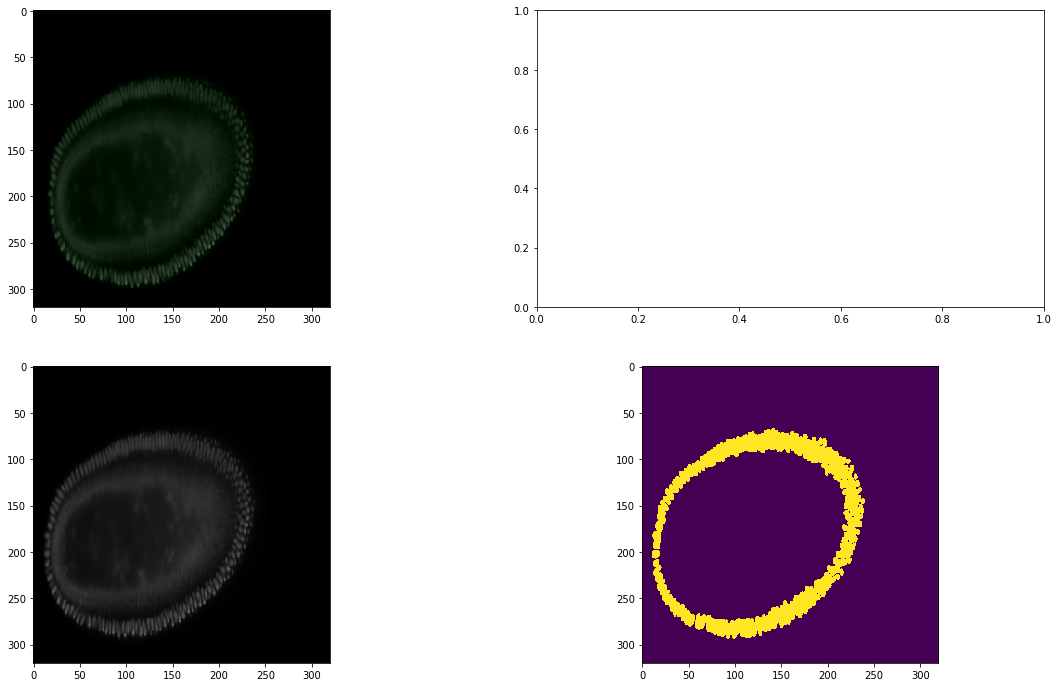

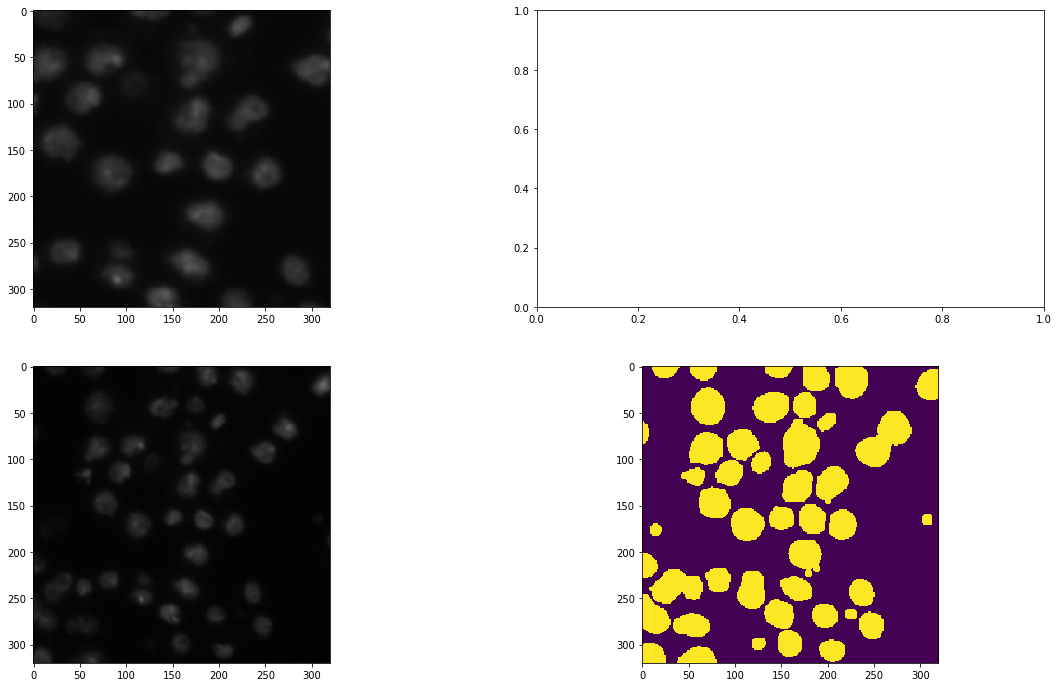

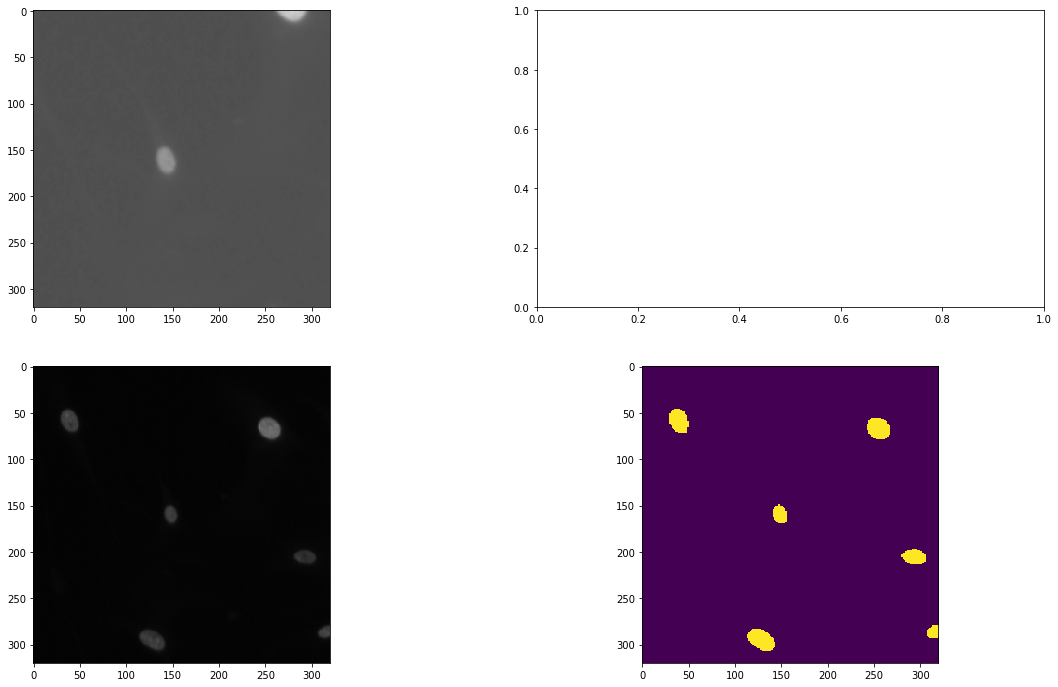

In [21]:
# lets look at augmented images

for i in range(4):
    f, axarr = plt.subplots(2,2)
    f.set_size_inches(20,12)
    index = random.randint(0, len(train_generator.x))

    # Augmented Images
    img = np.array(X_train[index], dtype = 'uint8')
    transformed = transform(image = img)
    trans_image = transformed['image']

    axarr[0,0].imshow(trans_image)
    # axarr[0,1].imshow(np.squeeze(trans_mask))
    axarr[1,0].imshow(X_train[index])
    axarr[1,1].imshow(np.squeeze(Y_train[index]))


# Baseline Model U-Net

> U-Net model,  [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/pdf/1505.04597.pdf) (https://github.com/jocicmarko/ultrasound-nerve-segmentation) из Kaggle Ultrasound Nerve Segmentation competition.

![](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

**The Jaccard similarity index (sometimes called the Jaccard similarity coefficient) 
compares members for two sets to see which members are shared and which are distinct. 
It’s a measure of similarity for the two sets of data, with a range from 0% to 100%. 
The higher the percentage, the more similar the two populations.**

**The formula to find the Index is:
Jaccard Index = (the number in both sets) / (the number in either set) * 100
The same formula in notation is:
J(X,Y) = |X∩Y| / |X∪Y|**
    

**Count the number of members which are shared between both sets.
Count the total number of members in both sets (shared and un-shared).
Divide the number of shared members (1) by the total number of members (2).
Multiply the number you found in (3) by 100.**

In [22]:
from keras import backend as K

# Jaccard coefficient function for metrics in training.

def jacard_cof(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    val = (intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
    
    return val

In [23]:
# Build U-Net model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p4)
c5 = BatchNormalization() (c5)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
optimizer = Adam() # Adamax(ExponentialDecay(0.01, 100, 0.9))
model.compile(
    optimizer=optimizer, 
    #loss=combo_loss, 
    loss='binary_crossentropy',
    #loss=tf.keras.metrics.binary_focal_crossentropy,
    #loss = 'sparse_categorical_crossentropy',
    metrics=[jacard_cof]
)

# model.summary()

In [24]:
checkpoint = ModelCheckpoint('best_model.hdf5',
                             monitor='val_jacard_cof',
                             verbose=1,
                             mode='max',
                             save_best_only=True)
callbacks_list = [checkpoint]

In [25]:
# Fit model
history = model.fit(X_train, Y_train, 
                    validation_split=validation_split, 
                    batch_size=BATCH_SIZE, 
                    epochs=90, 
                    callbacks = callbacks_list,
                    verbose=2,)

Train on 569 samples, validate on 101 samples
Epoch 1/90
 - 14s - loss: 0.4437 - jacard_cof: 0.1245 - val_loss: 0.4270 - val_jacard_cof: 0.1379

Epoch 00001: val_jacard_cof improved from -inf to 0.13785, saving model to best_model.hdf5
Epoch 2/90
 - 6s - loss: 0.2521 - jacard_cof: 0.2007 - val_loss: 0.3160 - val_jacard_cof: 0.1813

Epoch 00002: val_jacard_cof improved from 0.13785 to 0.18125, saving model to best_model.hdf5
Epoch 3/90
 - 6s - loss: 0.2037 - jacard_cof: 0.2528 - val_loss: 0.2219 - val_jacard_cof: 0.2385

Epoch 00003: val_jacard_cof improved from 0.18125 to 0.23847, saving model to best_model.hdf5
Epoch 4/90
 - 6s - loss: 0.1828 - jacard_cof: 0.2852 - val_loss: 0.2439 - val_jacard_cof: 0.2483

Epoch 00004: val_jacard_cof improved from 0.23847 to 0.24828, saving model to best_model.hdf5
Epoch 5/90
 - 6s - loss: 0.1696 - jacard_cof: 0.3245 - val_loss: 0.1560 - val_jacard_cof: 0.3276

Epoch 00005: val_jacard_cof improved from 0.24828 to 0.32764, saving model to best_model.h

In [26]:
# model.save('keras_unet.h5')
# # Load best
# model.load_weights('best_model.hdf5')


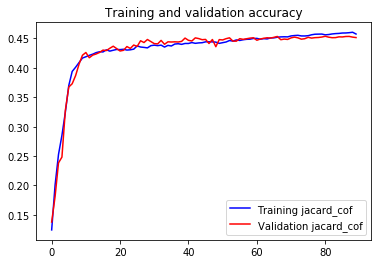

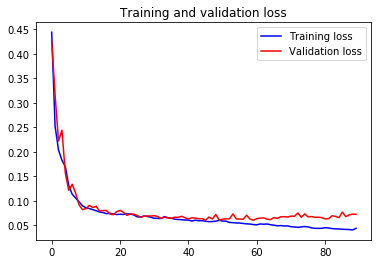

In [27]:

acc = history.history['jacard_cof']

val_acc = history.history['val_jacard_cof']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(val_acc))
 
plt.plot(epochs, acc, 'b', label='Training jacard_cof')
plt.plot(epochs, val_acc, 'r', label='Validation jacard_cof')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [28]:
# After with experimenting with the model above and changing different parameters
# and image sizes. The best resutl I got on testing data was around 0.457 or 45.7.


# U-Net with Backbone CNN from segmentation_models library

In [29]:
!pip install segmentation_models

import segmentation_models as sm
from segmentation_models import Unet

Segmentation Models: using `keras` framework.


In [30]:
# Building segmentation model from segmentation_models with backbone.

Backbone = 'seresnet34'
preprocess_input = sm.get_preprocessing(Backbone)

# preprocess input
x_train = preprocess_input(train_generator.x)
x_val = preprocess_input(test_generator.x)

model_ = Unet(Backbone, encoder_weights='imagenet')
model_.compile(optimizer=Adam(learning_rate = 0.0005), loss='binary_crossentropy', metrics=[jacard_cof])

86319104/86315168 [==============================] - 3s 0us/step


In [31]:
checkpoint = ModelCheckpoint('best_model_.hdf5',
                             monitor='val_jacard_cof',
                             verbose=1,
                             mode='max',
                             save_best_only=True)
callbacks_list = [checkpoint]

In [32]:
%%time
# Fit model
history = model_.fit(x=x_train, 
                    
                    y=train_generator.y,
                    validation_data=(x_val, test_generator.y),
                    
                    batch_size=16,
                    epochs=170, 
                    callbacks = callbacks_list,
                    verbose=2,)

Train on 570 samples, validate on 100 samples
Epoch 1/170
 - 37s - loss: 0.3192 - jacard_cof: 0.2392 - val_loss: 0.8624 - val_jacard_cof: 0.1893

Epoch 00001: val_jacard_cof improved from -inf to 0.18926, saving model to best_model_.hdf5
Epoch 2/170
 - 14s - loss: 0.1446 - jacard_cof: 0.3466 - val_loss: 0.2616 - val_jacard_cof: 0.3061

Epoch 00002: val_jacard_cof improved from 0.18926 to 0.30614, saving model to best_model_.hdf5
Epoch 3/170
 - 14s - loss: 0.1060 - jacard_cof: 0.3857 - val_loss: 0.1439 - val_jacard_cof: 0.3611

Epoch 00003: val_jacard_cof improved from 0.30614 to 0.36110, saving model to best_model_.hdf5
Epoch 4/170
 - 14s - loss: 0.0928 - jacard_cof: 0.4015 - val_loss: 0.1179 - val_jacard_cof: 0.3895

Epoch 00004: val_jacard_cof improved from 0.36110 to 0.38951, saving model to best_model_.hdf5
Epoch 5/170
 - 14s - loss: 0.0835 - jacard_cof: 0.4129 - val_loss: 0.0942 - val_jacard_cof: 0.4025

Epoch 00005: val_jacard_cof improved from 0.38951 to 0.40252, saving model to

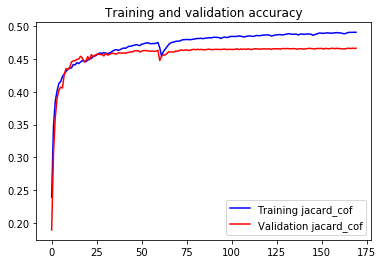

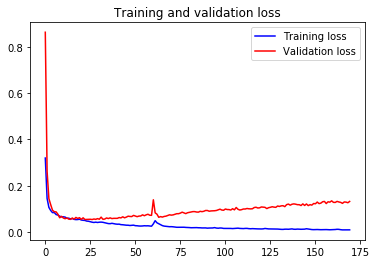

In [33]:
acc = history.history['jacard_cof']

val_acc = history.history['val_jacard_cof']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(val_acc))
 
plt.plot(epochs, acc, 'b', label='Training jacard_cof')
plt.plot(epochs, val_acc, 'r', label='Validation jacard_cof')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

# Model predictions with test data

Смотриться хорошо

In [34]:
# Get test data
X_test = get_X_data(TEST_PATH, output_shape=(IMG_HEIGHT,IMG_WIDTH))

Y_hat = model_.predict(preprocess_input(X_test))
Y_hat.shape


# img_col = []

# X_test_ = rgb2gray(X_test)
# print(X_test_.shape)
# for img in X_test_:
    
#     X_test__ = chan_vese(img,max_iter=100,extended_output=True)
#     img_col.append(X_test__[1])
    







# img_col = np.array(img_col, dtype='float32')
# X_test_ = img_col.reshape((len(X_test), 320, 320,1))
# X_test = X_test_

# Use model to predict test labels
#Y_hat = model.predict(X_test, verbose=1)
#Y_hat.shape



(65, 320, 320, 1)

(320, 320, 3)


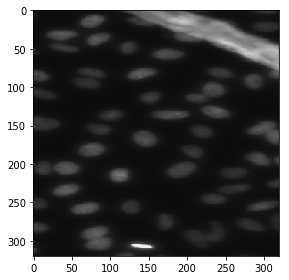

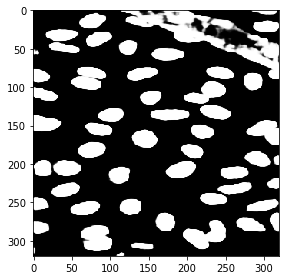

In [35]:
idx = random.randint(0, len(test_ids[1]))
print(X_test[idx].shape)
skimage.io.imshow(X_test[idx])
plt.show()
skimage.io.imshow(Y_hat[idx][:,:,0])
plt.show()

# Encode and Submit Test Data Predictions

In [36]:
# Run-length encoding stolen from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)

In [37]:
# Upsample Y_hat back to the original X_test size (height and width)
Y_hat_upsampled = []
for i, test_id in enumerate(os.listdir(TEST_PATH)):  #loop through test_ids in the test_path
    img = skimage.io.imread('{0}/{1}/images/{1}.png'.format(TEST_PATH, test_id))  #read original test image directly from path
    img_upscaled = skimage.transform.resize(Y_hat[i], (img.shape[0], img.shape[1]), mode='constant', preserve_range=True)  #upscale Y_hat image according to original test image
    Y_hat_upsampled.append(img_upscaled)   #append upscaled image to Y_hat_upsampled
len(Y_hat_upsampled)

65

In [38]:
# Apply Run-Length Encoding on our Y_hat_upscaled
new_test_ids = []
rles = []
for n, id_ in enumerate(os.listdir(TEST_PATH)):
    rle = list(prob_to_rles(Y_hat_upsampled[n]))
    rles.extend(rle)
    new_test_ids.extend([id_] * len(rle))
len(new_test_ids)  #note that for each test_image, we can have multiple entries of encoded pixels

3072

In [39]:
# Create submission DataFrame
sub = pd.DataFrame()
sub['ImageId'] = new_test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv('submission_prediction_.csv', index=False)